# Interpretability of autoencoder latent space for passengers demand-sensitive planning on high-speed railways (IWANN 2023)


In [1]:
import datetime
import math
import nltk
import numpy as np
import os
import pandas as pd
import random

from feature_engine.creation import CyclicalFeatures
from nltk.corpus import wordnet
from sklearn.preprocessing import MinMaxScaler
from scipy import spatial
from typing import Dict, List, Tuple

EMBEDDING_DIM = 50

In [2]:
# Download wordnet if not already downloaded
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/david/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
from src.robin.supply.entities import Supply

def get_paths_from_supply(path_config_supply: str = '../configs/test_case/supply_data.yml') -> List[List[str]]:
    """
    Get the paths of a supply

    Args:
        path_config_supply (str, optional): Path to the supply config file. Defaults to '../configs/test_case/supply_data.yml'.

    Returns:
        List[List[str]]: List of paths
    """
    supply = Supply.from_yaml(path_config_supply)

    # Get set of corridors
    corridors = []
    for service in supply.services:
        if service.line.corridor not in corridors:
            corridors.append(service.line.corridor)

    # Get set of paths
    paths = []
    for corridor in corridors:
        for path in corridor.paths:
            if path not in paths:
                paths.append(path)

    # Parse paths of Station objects to paths of station mame
    paths = [[station.name.replace("-", " ").split(" ")[0].lower() for station in path] for path in paths]
    return paths

paths = get_paths_from_supply()
print(paths)

[['madrid', 'guadalajara', 'calatayud', 'zaragoza', 'lleida', 'tarragona', 'barcelona', 'girona', 'figueres']]


In [4]:
def get_word_syn(word: str) -> str:
    """
    Get a random synonym of a word

    Args:
        word (str): Word to get the synonym from

    Returns:
        str: Synonym of the word
    """
    word_synset = wordnet.synsets(word)
    if len(word_synset) > 0:
        station_synset = word_synset[0]
        station_lemmas = station_synset.lemmas()
        if len(station_lemmas) > 0:
            word_lemma = random.choice(station_lemmas)
            return word_lemma.name().lower()

    return word

def get_random_pair(paths: list[list]) -> Tuple[str, str]:
    """
    Get a random pair of stations from a path

    Args:
        paths (list[list]): List of stations

    Returns:
        Tuple[str, str]: Tuple with the origin and destination stations
    """
    random_path = random.choice(paths)  # Choose a random path

    origin_index = random.randint(0, len(random_path) - 2)  # Choose a random origin station
    destination_index = random.randint(origin_index + 1, len(random_path) - 1)  # Choose a random destination station

    origin_station = random_path[origin_index]
    destination_station = random_path[destination_index]
    return origin_station, destination_station

In [5]:
def get_renfe_station_id(adif_id: str, stations_df: pd.DataFrame) -> str:
    """
    Returns the Station name given the Adif station id.

    Args:
        adif_id (str): Adif station id.
        stations_df (pd.DataFrame): Dataframe with the stations' information.

    Returns:
        str: Station name.
    """
    station_name = stations_df[stations_df['stop_id'] == adif_id]['stop_name'].values[0]
    station_name = station_name.replace("-", " ").split(" ")[0].lower()
    return station_name

stations_csv_path = f'../data/renfe/renfe_stations.csv'
stations_df = pd.read_csv(stations_csv_path, dtype={'stop_id': str, 'renfe_id': str})

In [6]:
def simulate_passengers_data(paths: list, user_patterns: list, n_passengers: int = 10000, seed: int = 42) -> pd.DataFrame:
    # Set random state
    random.seed(seed)

    pairs = []
    for _ in range(n_passengers):
        pairs.append(get_random_pair(paths))

    df = pd.DataFrame(pairs, columns=['origin', 'destination'])
    df['user_pattern'] = [random.choice(user_patterns) for _ in range(n_passengers)]

    random_days = lambda: random.randint(0, 365*10)
    random_hours = lambda: random.randint(0, 24)
    random_minutes = lambda: random.randint(0,60)

    random_timedelta = lambda: datetime.timedelta(days=random_days(), hours=random_hours(), minutes=random_minutes())
    df['arrival_date'] = [datetime.datetime(2021, 1, 1) + random_timedelta() for _ in range(n_passengers)]
    df['week_day'] = [date.strftime('%A').lower() for date in df['arrival_date']]
    df['month'] = [date.strftime('%B').lower() for date in df['arrival_date']]
    df['time'] = [date.time() for date in df['arrival_date']]
    df.drop(columns=['arrival_date'], inplace=True)
    return df

user_patterns = ("business", "student", "tourist")
df = simulate_passengers_data(paths, user_patterns, n_passengers=10000)
print(df.head())

        origin  destination user_pattern   week_day    month      time
0       madrid    tarragona      tourist     monday      may  14:39:00
1     zaragoza    tarragona     business    tuesday  january  23:52:00
2  guadalajara    barcelona     business     friday   august  01:46:00
3       madrid  guadalajara      student  wednesday   august  07:48:00
4     zaragoza    tarragona      student     monday   august  04:15:00


In [7]:
class AutoencoderEmbedding:
    """
    Class to get the embedding of a dataframe to be used as input of an autoencoder

    Attributes:
        df (pd.DataFrame): Dataframe with the data to be embedded
        df_embedding (pd.DataFrame): Dataframe with the embedding.
        embedding_dim (int, optional): Embedding dimension. Defaults to 50.
        embedding_dict (dict): Dictionary with the embedding.
        scaler (MinMaxScaler): Scaler to normalize the data.
        cyclical (CyclicalFeatures): Cyclical features transformer.
        df_time (pd.DataFrame): Dataframe with the time embedding.
        input_arrays (list[np.array]): List of arrays with the embedded input data.
    """
    def __init__(self, df: pd.DataFrame, embedding_dim: int = 50):
        """
        Constructor method

        Args:
            df (pd.DataFrame): Dataframe with the data to be embedded
            embedding_dim (int, optional): Embedding dimension. Defaults to 50.
        """
        self.df = df
        self.df_embedding = pd.DataFrame()
        self.embedding_dim = embedding_dim
        self.embedding_dict = self._get_embedding_dict()
        self.scaler = MinMaxScaler()
        self.cyclical = CyclicalFeatures(variables=['time'], drop_original=True)
        self.input_arrays = self._get_input_arrays()

    def _get_embedding_dict(self) -> Dict[str, np.array]:
        """
        Get the words embedding dictionary

        Returns:
            Dict[str, np.array]: Dictionary with the embedding.
        """
        # Get bag of words
        words_set = set(self.df[['origin', 'destination', 'user_pattern', 'week_day', 'month']].values.flatten())
        word_index = {word: index for index, word in enumerate(words_set)}

        embeddings_index = {}
        f = open(os.path.join('../data/pretrained/glove6B/glove.6B.50d.txt'))

        # Read GloVe embeddings
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype=np.float32)
            embeddings_index[word] = coefs
        f.close()

        # Create embedding matrix
        embedding_matrix = np.zeros((len(word_index) + 1, self.embedding_dim))
        embedding_dict = {}
        for word, i in word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                embedding_dict[word] = embedding_vector

        return embedding_dict

    def _get_input_arrays(self) -> np.array:
        """
        Get the input arrays

        Returns:
            np.array: Array with the embedded input data.
        """
        self.df_embedding['origin'] = self.df['origin'].apply(lambda x: self.embedding_dict.get(x))
        self.df_embedding['destination'] = self.df['destination'].apply(lambda x: self.embedding_dict.get(x))
        self.df_embedding['user_pattern'] = self.df['user_pattern'].apply(lambda x: self.embedding_dict.get(x))
        self.df_embedding['week_day'] = self.df['week_day'].apply(lambda x: self.embedding_dict.get(x))
        self.df_embedding['month'] = self.df['month'].apply(lambda x: self.embedding_dict.get(x))

        def encode_time(time: datetime.time) -> np.float32:
            total_minutes = (time.hour * 60) + time.minute
            total_degrees = (total_minutes / (24 * 60)) * 360
            encoded_value = math.sin(math.radians(total_degrees))
            return np.float32(encoded_value)

        self.df_embedding['time'] = self.df['time'].apply(lambda x: encode_time(x))

        self.df_embedding = self.df_embedding[['origin', 'destination', 'user_pattern', 'week_day', 'month']]
        input_data = self.df_embedding[['origin', 'destination', 'user_pattern', 'week_day', 'month']].values.tolist()
        return np.array([np.asarray(row, dtype=np.float32) for row in input_data])

In [8]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

print("Train data shape: ", df_train.shape)
print("Test data shape: ", df_test.shape)

train_embedding = AutoencoderEmbedding(df = df_train, embedding_dim=EMBEDDING_DIM)
test_embedding = AutoencoderEmbedding(df = df_test, embedding_dim=EMBEDDING_DIM)

print("Test data autoencoder input shape: ", test_embedding.input_arrays.shape)
print("First test data instance: ", test_embedding.df.iloc[0])
print("First test data instance embedded: ", test_embedding.input_arrays[0])

Train data shape:  (7000, 6)
Test data shape:  (3000, 6)
Test data autoencoder input shape:  (3000, 5, 50)
First test data instance:  origin          zaragoza
destination       lleida
user_pattern     student
week_day          sunday
month               june
time            22:10:00
Name: 6252, dtype: object
First test data instance embedded:  [[ 1.0642    0.089939 -0.28715   0.82471   0.31063  -1.4798    0.12028
   0.7449   -1.2919    0.39737   0.4715   -0.53483  -0.48049  -1.2998
   0.32826  -1.3085   -0.67916  -0.20625  -0.7232    0.41638  -1.2895
  -0.69963  -0.23631   0.70175  -0.61498   0.20193   1.329     0.25294
  -0.093715 -0.16535   0.99605   1.2007   -0.26729  -0.42035  -0.15881
   0.63906  -0.73977   1.3119    0.61136  -0.59197   1.3032    0.16094
  -0.027686 -0.9412   -0.68288   0.65116   0.47976  -0.32516   1.3912
  -0.50467 ]
 [ 0.23779  -0.70155  -1.123     0.36108  -1.1387   -0.49992   0.28795
   0.87089  -0.32366   0.85312   1.5365   -1.2579    0.45029  -0.87621
  -0.

## Embedding Model

## Autoencoder model

In [9]:
import tensorflow as tf
from keras.layers import Input, GRU, Dense, RepeatVector, TimeDistributed
from keras.models import Model

input_shape = (5, EMBEDDING_DIM)
output_shape = (5, EMBEDDING_DIM)

latent_dim = 5

inputs = Input(shape=input_shape)

encoder = GRU(64, return_sequences=True)(inputs)
encoder = GRU(32)(encoder)

dense1 = Dense(latent_dim)(encoder)
decoder_inputs = Input(shape=(latent_dim,))
decoder = RepeatVector(input_shape[0])(decoder_inputs)
decoder = GRU(32, return_sequences=True)(decoder)
decoder = GRU(64, return_sequences=True)(decoder)
decoder_outputs = TimeDistributed(Dense(output_shape[1]))(decoder)

encoder_model = Model(inputs, dense1)
decoder_model = Model(decoder_inputs, decoder_outputs)

model = Model(inputs, decoder_model(dense1))

model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])
model.summary()

2023-05-18 00:07:08.408834: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 00:07:11.902303: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 50)]           0         
                                                                 
 gru (GRU)                   (None, 5, 64)             22272     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
 model_1 (Functional)        (None, 5, 50)             25810     
                                                                 
Total params: 57,655
Trainable params: 57,655
Non-trainable params: 0
_________________________________________________________________


In [20]:
import tensorflow as tf
from keras.layers import Input, GRU, Dense, RepeatVector, TimeDistributed
from keras.models import Model
from keras import backend as K

beta = 5

input_shape = (4, EMBEDDING_DIM)
output_shape = (4, EMBEDDING_DIM)
latent_dim = 4

inputs = Input(shape=input_shape)

# Encoder
encoder = GRU(64, return_sequences=True)(inputs)
encoder = GRU(32)(encoder)

# Latent layer
z_mean = Dense(latent_dim)(encoder)
z_log_var = Dense(latent_dim)(encoder)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = tf.keras.layers.Lambda(sampling)([z_mean, z_log_var])

# Decoder
decoder_inputs = Input(shape=(latent_dim,))
decoder = RepeatVector(input_shape[0])(decoder_inputs)
decoder = GRU(32, return_sequences=True)(decoder)
decoder = GRU(64, return_sequences=True)(decoder)
decoder_outputs = TimeDistributed(Dense(output_shape[1]))(decoder)

# Use z_mean as encoder output to obtain a disentangled latent representation
encoder_model = Model(inputs, z_mean)

decoder_model = Model(decoder_inputs, decoder_outputs)

# VAE model
vae_outputs = decoder_model(z)
model = Model(inputs, vae_outputs)

# Loss function
reconstruction_loss = tf.keras.losses.mean_squared_error(K.flatten(inputs), K.flatten(vae_outputs))
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + beta * kl_loss)
model.add_loss(vae_loss)

model.compile(optimizer='rmsprop', loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 4, 50)]      0           []                               
                                                                                                  
 gru_4 (GRU)                    (None, 4, 64)        22272       ['input_3[0][0]']                
                                                                                                  
 gru_5 (GRU)                    (None, 32)           9408        ['gru_4[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 4)            132         ['gru_5[0][0]']                  
                                                                                            

In [22]:
import tensorflow as tf
from keras.layers import Input, Conv1D, GlobalMaxPooling1D, Conv1DTranspose
from keras.models import Model
from keras import backend as K

beta = 5
SEQUENCE_LENGTH = 4

input_shape = (SEQUENCE_LENGTH, EMBEDDING_DIM)
latent_dim = 4

inputs = Input(shape=input_shape)

# Encoder
encoder = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
encoder = Conv1D(32, kernel_size=3, activation='relu', padding='same')(encoder)
encoder = GlobalMaxPooling1D()(encoder)

# Latent space
z_mean = Dense(latent_dim)(encoder)
z_log_var = Dense(latent_dim)(encoder)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = tf.keras.layers.Lambda(sampling)([z_mean, z_log_var])

# Decoder
decoder = Dense(32 * SEQUENCE_LENGTH, activation='relu')(z)
decoder = tf.keras.layers.Reshape((SEQUENCE_LENGTH, 32))(decoder)
decoder = Conv1DTranspose(32, kernel_size=3, activation='relu', padding='same')(decoder)
decoder = Conv1DTranspose(64, kernel_size=3, activation='relu', padding='same')(decoder)
decoder_outputs = Conv1DTranspose(EMBEDDING_DIM, kernel_size=3, padding='same')(decoder)

encoder_model = Model(inputs, z_mean)
decoder_model = Model(z, decoder_outputs)

vae_outputs = decoder_model(z)
model = Model(inputs, vae_outputs)

# Loss function
reconstruction_loss = tf.keras.losses.mean_squared_error(K.flatten(inputs), K.flatten(vae_outputs))
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + beta * kl_loss)
model.add_loss(vae_loss)

model.compile(optimizer='rmsprop', loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 4, 50)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 4, 64)        9664        ['input_5[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 4, 32)        6176        ['conv1d[0][0]']                 
                                                                                                  
 global_max_pooling1d (GlobalMa  (None, 32)          0           ['conv1d_1[0][0]']               
 xPooling1D)                                                                                

In [10]:
history = model.fit(x = train_embedding.input_arrays,
                    y = train_embedding.input_arrays,
                    epochs=10,
                    batch_size=32,
                    verbose=1)

Epoch 1/10
219/219 [==============================] - 7s 10ms/step - loss: 0.2014 - mean_squared_error: 0.2014
Epoch 2/10
219/219 [==============================] - 2s 9ms/step - loss: 0.0860 - mean_squared_error: 0.0860
Epoch 3/10
219/219 [==============================] - 2s 9ms/step - loss: 0.0475 - mean_squared_error: 0.0475
Epoch 4/10
219/219 [==============================] - 2s 9ms/step - loss: 0.0328 - mean_squared_error: 0.0328
Epoch 5/10
219/219 [==============================] - 2s 9ms/step - loss: 0.0250 - mean_squared_error: 0.0250
Epoch 6/10
219/219 [==============================] - 2s 9ms/step - loss: 0.0190 - mean_squared_error: 0.0190
Epoch 7/10
219/219 [==============================] - 2s 9ms/step - loss: 0.0139 - mean_squared_error: 0.0139
Epoch 8/10
219/219 [==============================] - 2s 9ms/step - loss: 0.0112 - mean_squared_error: 0.0112
Epoch 9/10
219/219 [==============================] - 2s 9ms/step - loss: 0.0100 - mean_squared_error: 0.0100
Epoch 10/

## Plot history

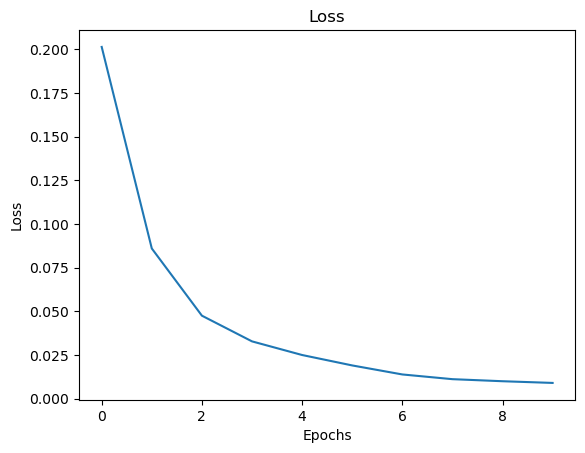

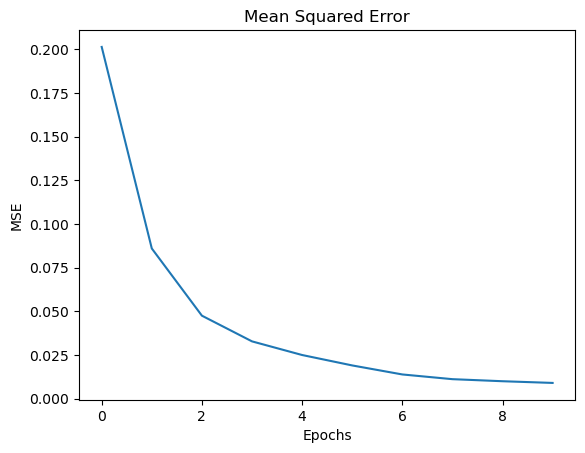

In [11]:
# Plot history loss and mse

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(history.history['mean_squared_error'], label='mse')
plt.title('Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [18]:
# Evaluate model
score = model.evaluate(test_embedding.input_arrays, test_embedding.input_arrays, verbose=1)

94/94 [==============================] - 0s 2ms/step - loss: 0.0085 - mean_squared_error: 0.0085


## Make predictions

In [12]:
def find_closest_embeddings(embedding, emb):
    return sorted(emb.keys(), key=lambda word: spatial.distance.euclidean(emb[word], embedding))[0]

In [15]:
random_index = np.random.randint(0, len(test_embedding.input_arrays))
random_vector = test_embedding.input_arrays[random_index]

print("Input - Random passenger data: ")
print(test_embedding.df.iloc[random_index])

latent_passenger = encoder_model.predict(np.array([random_vector]))[0]
print("Passenger latent representation: ", latent_passenger)
print()

prediction = model.predict(np.array([random_vector]))[0]

print("Output - Passenger reconstruction: ")
decoded_prediction = [find_closest_embeddings(word_vector, test_embedding.embedding_dict) for word_vector in prediction]
print(decoded_prediction)

#print("Time prediction: ", prediction[-1])
#predicted_year = test_embedding.scaler.inverse_transform(np.array([prediction[-1][:1]]))
#print(int(predicted_year[0][0]))

Input - Random passenger data: 
origin            madrid
destination       girona
user_pattern    business
week_day         tuesday
month                may
time            21:21:00
Name: 9579, dtype: object
1/1 [==============================] - 0s 19ms/step
Passenger latent representation:  [ 7.3532076   1.3819605   3.6512246  -3.7424912  -0.39898577]

1/1 [==============================] - 0s 24ms/step
Output - Passenger reconstruction: 
['madrid', 'girona', 'business', 'tuesday', 'april']


Mes y día como palabra, hora pensar idea para representar (ángulo?)

## Estudio de la correlación entre factores latentes y la entrada del autoencoder